In [129]:
import imp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

import pickle


In [130]:
df = pd.read_csv("data.csv")
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


# Data Quality Analysis

In [131]:
print("--- Data Quality Report ---")
print(f"Shape: {df.shape}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nDuplicate Rows: {df.duplicated().sum()}")


--- Data Quality Report ---
Shape: (2111, 17)

Missing Values:
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

Duplicate Rows: 24


In [132]:
print(f"\nData Types:\n{df.dtypes}")


Data Types:
Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


In [133]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


In [134]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in '{col}':\n", df[col].unique())


Unique values in 'Gender':
 ['Female' 'Male']

Unique values in 'family_history_with_overweight':
 ['yes' 'no']

Unique values in 'FAVC':
 ['no' 'yes']

Unique values in 'CAEC':
 ['Sometimes' 'Frequently' 'Always' 'no']

Unique values in 'SMOKE':
 ['no' 'yes']

Unique values in 'SCC':
 ['no' 'yes']

Unique values in 'CALC':
 ['no' 'Sometimes' 'Frequently' 'Always']

Unique values in 'MTRANS':
 ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']

Unique values in 'NObeyesdad':
 ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


Outlier counts per column:
Age       168
Height      1
Weight      1
NCP       579
dtype: int64


<Axes: >

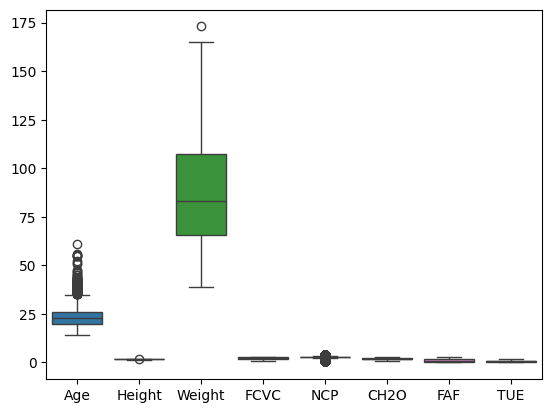

In [135]:
numeric_df = df.select_dtypes(include=['number'])

Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

outliers = ((numeric_df < (Q1 - 1.5 * IQR)) | 
            (numeric_df > (Q3 + 1.5 * IQR))).sum()

print("Outlier counts per column:")
print(outliers[outliers > 0])

sns.boxplot(data=df.select_dtypes(include=['number']))


# DATA CLEANING

In [136]:
df = df.drop_duplicates()

In [137]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['number']).columns

# Calculate Q1, Q3 and IQR
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df = df[~((df[numerical_cols] < lower_bound) | (df[numerical_cols] > upper_bound)).any(axis=1)]


In [138]:
le = LabelEncoder()

for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

In [139]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,2,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,1,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,0,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,0,4,5
5,1,29.0,1.62,53.0,0,1,2.0,3.0,2,0,2.0,0,0.0,0.0,1,0,1


In [140]:
df.dtypes

Gender                              int64
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight      int64
FAVC                                int64
FCVC                              float64
NCP                               float64
CAEC                                int64
SMOKE                               int64
CH2O                              float64
SCC                                 int64
FAF                               float64
TUE                               float64
CALC                                int64
MTRANS                              int64
NObeyesdad                          int64
dtype: object

In [141]:
df.shape

(1388, 17)

# FEATURE ENGINEERING

In [142]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,2,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,1,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,0,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,0,4,5
5,1,29.0,1.62,53.0,0,1,2.0,3.0,2,0,2.0,0,0.0,0.0,1,0,1


In [143]:
df["BMI"] = df["Weight"] / (df["Height"] ** 2)
df["Wt_Ht_ratio"] = df["Weight"] / df["Height"]
df["Active_transport"] = df["MTRANS"].isin(["Walking", "Bike"]).astype(int)
df["Activity_score"] = df["FAF"] + df["Active_transport"]
df["Diet_score"] = (df["FCVC"] +df["NCP"] -(df["FAVC"] == "yes").astype(int))



df.drop(columns=["Weight", "Height"], inplace=True)



# FEATURE RELATIONS

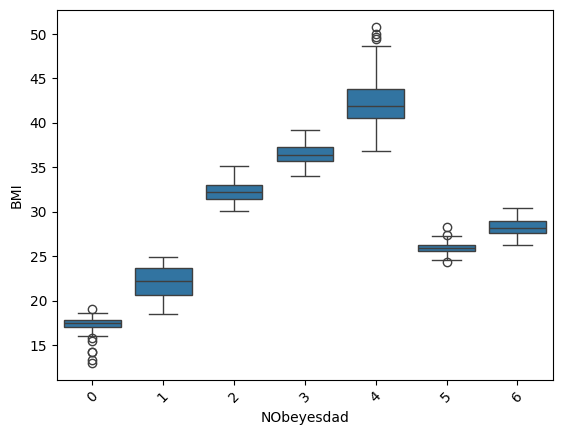

In [144]:
sns.boxplot(x="NObeyesdad", y="BMI", data=df)
plt.xticks(rotation=45)
plt.show()

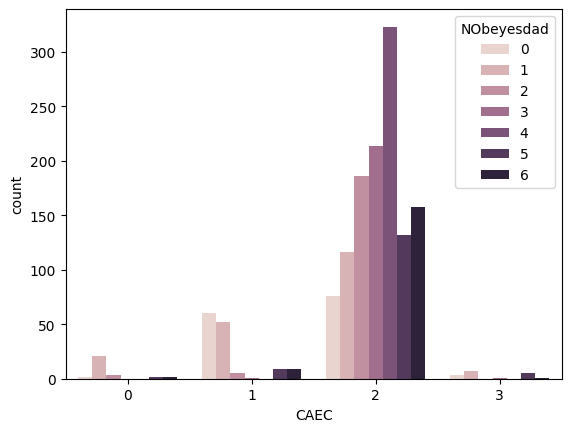

In [145]:
sns.countplot(x="CAEC", hue="NObeyesdad", data=df)
plt.show()

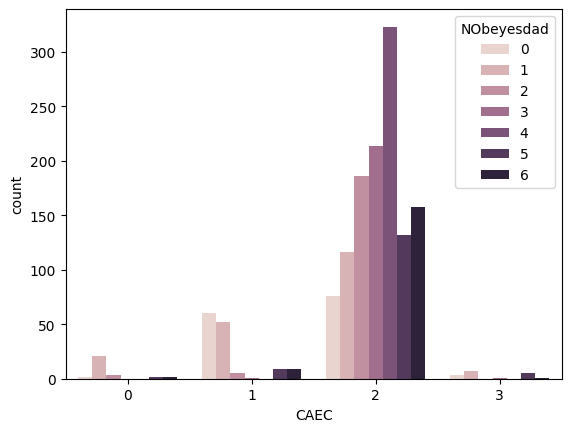

In [146]:
sns.countplot(x="CAEC", hue="NObeyesdad", data=df)
plt.show()


In [147]:
df.head()

,Gender,Age,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Wt_Ht_ratio,Active_transport,Activity_score,Diet_score
0,0,21.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,2,3,1,24.386526,39.506173,0,0.0,5.0
1,0,21.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,1,3,1,24.238227,36.842105,0,3.0,6.0
2,1,23.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,0,3,1,23.765432,42.777778,0,2.0,5.0
3,1,27.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,0,4,5,26.851852,48.333333,0,2.0,6.0
5,1,29.0,0,1,2.0,3.0,2,0,2.0,0,0.0,0.0,1,0,1,20.195092,32.716049,0,0.0,5.0


# MODEL GENERATION

In [148]:
os.makedirs("models", exist_ok=True)


X = df.drop(columns=["NObeyesdad"])
y = df["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


with open("models/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)


In [149]:
models = {
    "Logistic_Regression": LogisticRegression(max_iter=1000),
    
    "Decision_Tree": DecisionTreeClassifier(
        max_depth=8, random_state=42
    ),
    
    "KNN": KNeighborsClassifier(
        n_neighbors=7, weights="distance"
    ),
    
    "Naive_Bayes": GaussianNB(),
    
    "Random_Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=y.nunique(),
        random_state=42
    )
}


In [150]:
def evaluate_model(model, X_tr, X_te, y_tr, y_te):
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    y_prob = model.predict_proba(X_te)

    accuracy = accuracy_score(y_te, y_pred)
    precision = precision_score(y_te, y_pred, average="macro")
    recall = recall_score(y_te, y_pred, average="macro")
    f1 = f1_score(y_te, y_pred, average="macro")

    y_te_bin = label_binarize(y_te, classes=np.unique(y))
    auc = roc_auc_score(
        y_te_bin,
        y_prob,
        average="macro",
        multi_class="ovr"
    )

    return accuracy, auc, precision, recall, f1


In [151]:
results = []

for name, model in models.items():

    if name in ["Logistic_Regression", "KNN", "Naive_Bayes"]:
        metrics = evaluate_model(
            model,
            X_train_scaled,
            X_test_scaled,
            y_train,
            y_test
        )
    else:
        metrics = evaluate_model(
            model,
            X_train,
            X_test,
            y_train,
            y_test
        )

    # Save model
    with open(f"models/{name}.pkl", "wb") as f:
        pickle.dump(model, f)

    results.append([name, *metrics])


In [152]:
results_df = pd.DataFrame(
    results,
    columns=[
        "Model",
        "Accuracy",
        "AUC",
        "Precision",
        "Recall",
        "F1 Score"
    ]
)

print(results_df)
results_df.to_csv("performace.csv")


                 Model  Accuracy       AUC  Precision    Recall  F1 Score
0  Logistic_Regression  0.906475  0.993442   0.888474  0.891278  0.888619
1        Decision_Tree  0.978417  0.984991   0.974275  0.973648  0.973793
2                  KNN  0.798561  0.954636   0.767589  0.774744  0.763546
3          Naive_Bayes  0.755396  0.983751   0.855722  0.700148  0.698821
4        Random_Forest  0.982014  0.999925   0.981609  0.976411  0.978450
5              XGBoost  0.989209  0.999877   0.987228  0.988472  0.987688
